In [38]:

import jax
import os



os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

import math

from jax import grad

[cuda(id=0)]


In [39]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1] # Removing the last spurious element 

vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T


vmap_dst_2d = jit(vmap(dst_2d, in_axes = 0))#jit(vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1))
@jit
def double_dst_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A

# Defining the second order elliptic operators 
def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
    r =(x_1 - y_1) ** 2 + (x_2 - y_2) ** 2
    return jnp.exp(-r/length_scale)

In [40]:
length_scale = 1.0
matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

# 2D Elliptic PDE

In [41]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


We will consider 


We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\Delta u + bu&= \xi \\
u &= 0
\end{aligned}

We will consider a manufactured solution

\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}

Then 

$$
\xi =  \sum_{k=1}^\infty\sum_{l=1}^\infty u_{kl}(l^2 + k^2)^{-\alpha -\delta}(\pi^2(l^2 + k^2) + b)\sin(\pi k x) \sin(\pi l y)


In [42]:
#plt.style.use('default')
plt.style.use('plot_style-Examples_3d.txt')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [43]:
def evaluate_function_sine_2d(x, y, k,l ,c):
    values = c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    values = jnp.where(k==0, c*jnp.outer(jnp.ones_like(x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y)), values)
    values = jnp.where(l==0, c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.ones_like(y)), values)
    return values

In [44]:
def evaluate_basis_sine_2d(x,y,c):
    # The frequency starts at 0
    f_1 = jnp.arange(0, c.shape[0])
    f_2 = jnp.arange(0, c.shape[0])
    return jnp.sum(jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,0,None, 0), out_axes= -1), in_axes= (None, None, None, 0, 1),out_axes= -1))(x, y,f_1, f_2, c), axis = (2,3))#jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,None,0, 1)), in_axes= (None, None, 0, None, 0)))(x, y,f_1, f_2, c)#vmap(evaluate_function_sine_2d, in_axes=(None,None,0,0, 0))(x, y,f_1, f_2, c)


def evaluate_function_sine_2d_iterative(x,y,c):
    values = jnp.zeros_like(jnp.outer(x, y))
    for k in range(c.shape[0]):
        for l in range(c.shape[1]):
            values += c[k,l]*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    return values

In [45]:
key = random.PRNGKey(647023)
#key = random.PRNGKey(311)

n_coef = 2**7
print("Number of coefficients: ", n_coef)

nu = 1.0
b = 0.0


x_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
y_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
X, Y = jnp.meshgrid(x_finest, y_finest)
frequencies = jnp.arange(0, n_coef)

delta = .15
alpha = 1.0
random_draw =  random.normal(key, shape= (n_coef,n_coef))
decay = (jnp.arange(0,n_coef)[None]**2 + jnp.arange(0,n_coef)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_u= coef_u.at[:,0].set(0)
coef_u= coef_u.at[0,:].set(0)
coef_f =coef_u*((nu*jnp.pi**2*decay) +b)


Number of coefficients:  128


In [46]:
u_values = evaluate_basis_sine_2d(x_finest,y_finest, coef_u)
f_values =evaluate_basis_sine_2d(x_finest,y_finest, coef_f)

In [47]:
# u_values = evaluate_function_sine_2d_iterative(x_finest,y_finest, coef_u)
# f_values = evaluate_function_sine_2d_iterative(x_finest,y_finest, coef_f)

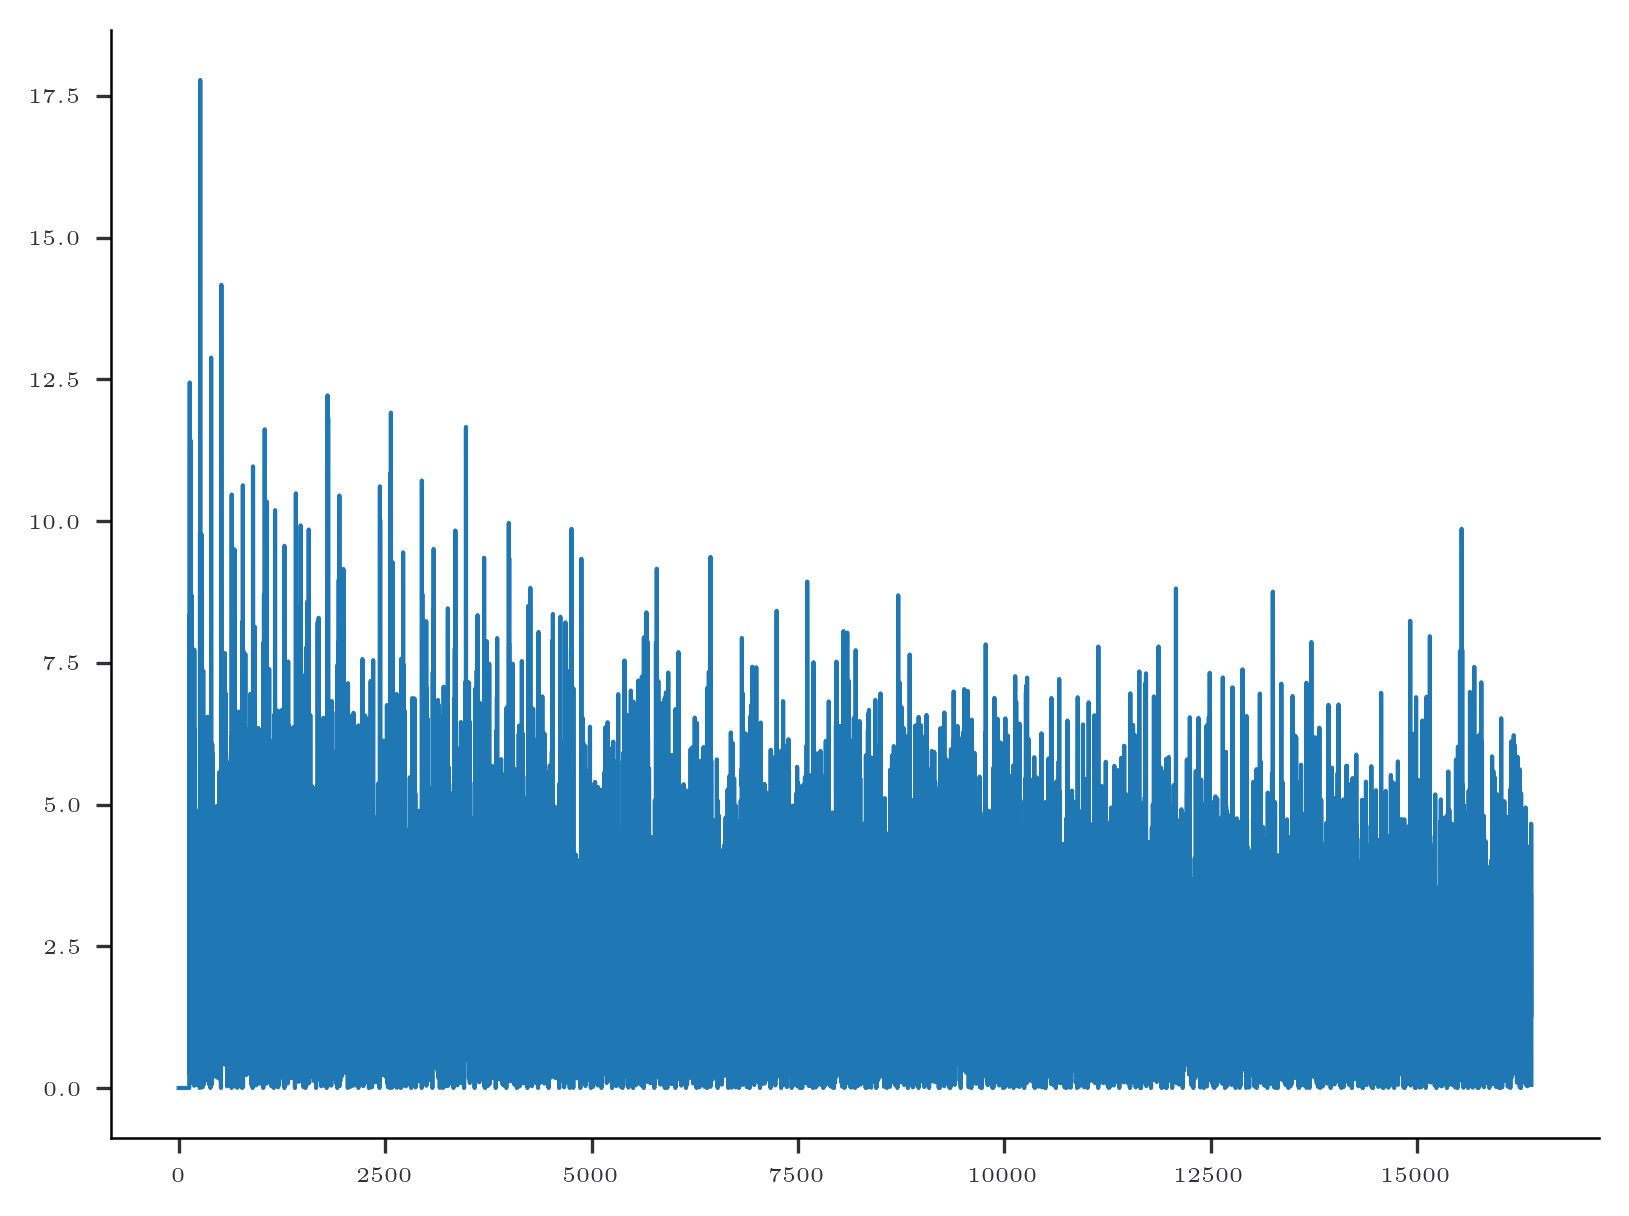

In [48]:
plt.plot(jnp.abs(coef_f).reshape(-1), label = "f")

In [49]:
# # Create a figure with two 3D subplots
# fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

# stride = 1
# ax.plot_surface(X, Y, evaluate_function_sine_2d(x_finest, y_finest, 1,2 ,1),  cmap='viridis', rstride=stride, cstride=stride)
# ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
# ax.set_xlabel(r'$x$')
# ax.set_ylabel(r'$t$')
# plt.show()

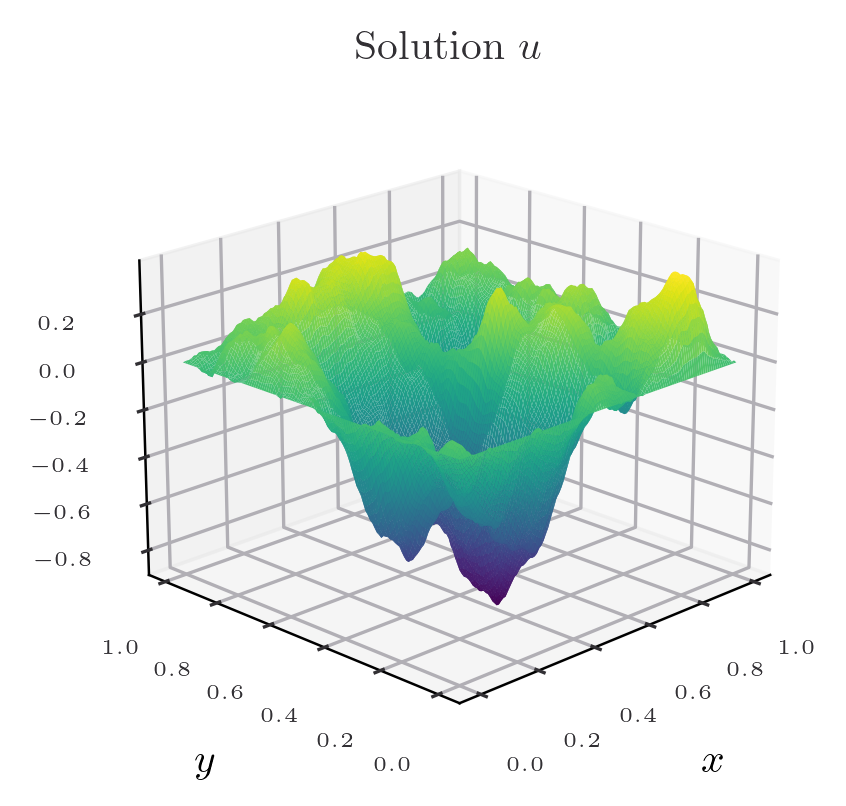

In [50]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

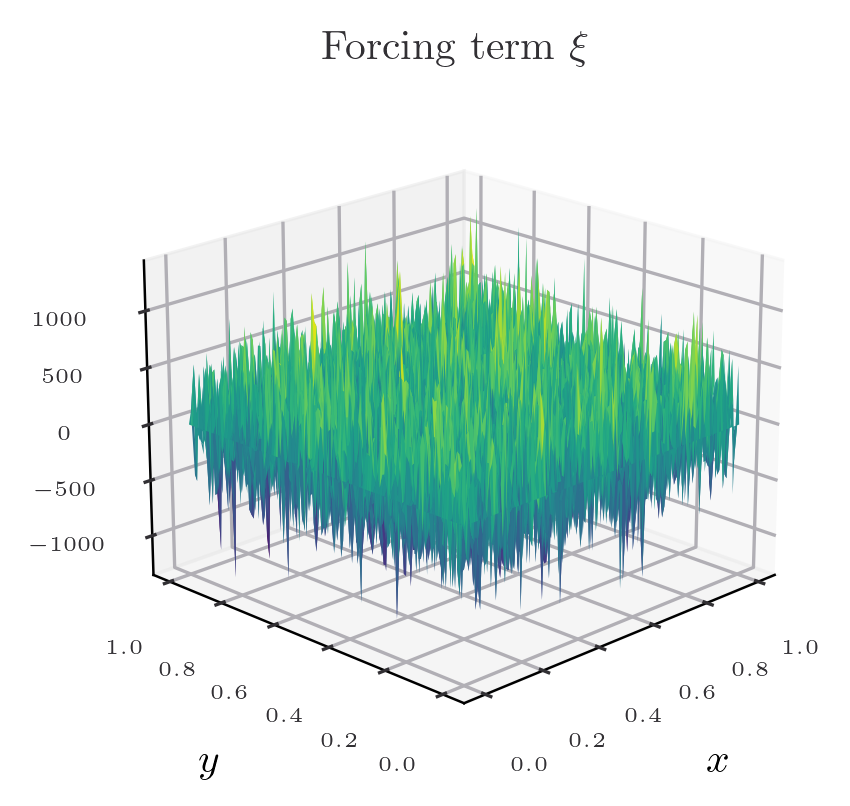

In [51]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [52]:
# u_trans = dst_2d(u_values)
# f_trans = dst_2d(f_values)
# print(jnp.mean(jnp.abs(u_trans- coef_u)), jnp.mean(jnp.abs(f_trans - coef_f)))

In [53]:
u_trans = dst_2d(u_values)
f_trans = dst_2d(f_values)
print(jnp.mean(jnp.abs(u_trans- coef_u)), jnp.mean(jnp.abs(f_trans - coef_f)))

3.598031870147873e-05 1.653286742451441


In [54]:
# i,j, k,l = 10,2,1,1
# test_values = jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x_finest), jnp.sqrt(2)*jnp.sin(jnp.pi*l*x_finest)) + 0.5*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*i*x_finest), jnp.sqrt(2)*jnp.sin(jnp.pi*j*x_finest))
# dst_2d(test_values)[k,l], dst_2d(test_values)[i,j]

# Solve the linear PDE

In [55]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


# 2d grid 
n_points = 2**6
print("Number of points {} ({} measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x, x, indexing='ij')

# Combine A and B into pairs
interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)
print(interior.shape)

Number of points 64 (4096 measurements)
(4096, 2)


In [56]:
# Create the boundary
n_boundary = 2**6
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

# Create a boundary
# Boundary points
boundary = jnp.linspace(0,1, n_boundary)

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 64 (256 total)


In [57]:
def matern_kernel(x, y, length_scale):
    r =jnp.sum((x - y) ** 2)
    return jnp.exp(-r/length_scale**2)

vmap_kernel_row = vmap(matern_kernel, in_axes=(None, 0, None))
# Now we apply vmap to the result to vectorize over the rows of the first argument
vmap_kernel = jit(vmap(vmap_kernel_row, in_axes=(0, None, None)))

# Defining the second order elliptic operators 
def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
    r =(x_1 - y_1) ** 2 + (x_2 - y_2) ** 2
    return  jnp.exp(-r/length_scale**2)

matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

In [58]:
def neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale):
    l_1 = grad(grad(matern_kernel_2d, argnums=0), argnums = 0)(x_1, x_2, y_1, y_2, length_scale)
    l_2 = grad(grad(matern_kernel_2d, argnums=1), argnums = 1)(x_1, x_2, y_1, y_2, length_scale)
    return -(l_1 + l_2)

def neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale):
    l_1 = grad(grad(matern_kernel_2d, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
    l_2 = grad(grad(matern_kernel_2d, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
    return -(l_1 + l_2)

def double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale):
    l_1 = grad(grad(neg_laplacian_x, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
    l_2 = grad(grad(neg_laplacian_x, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)

    return -(l_1 + l_2)

In [59]:
def L_b_x(x_1, x_2, y_1, y_2, length_scale, epsilon, b_x):
    return epsilon*neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale) + b_x*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)

def L_b_y(x_1, x_2, y_1, y_2, length_scale, epsilon, b_y):
    return epsilon*neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale) + b_y*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)

def L_b_xy(x_1, x_2, y_1, y_2, length_scale, epsilon, b_x, b_y):
    return epsilon**2*double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale) + epsilon*b_y*neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale) + epsilon*b_x*neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale)+ b_x*b_y*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)

L_b_xy_tensor = jit(vmap(vmap(vmap(vmap(L_b_xy, in_axes=(None, None,None, 0, None, None, None, None)), in_axes=(None, None, 0, None, None, None, None, None)), in_axes = (None, 0, None, None, None, None, None, None)), in_axes=(0, None, None, None, None, None, None, None)))
L_b_y_tensor_partial =vmap(vmap(vmap(L_b_y, in_axes=(None, None,None, 0, None, None, None)), in_axes=(None, None, 0, None, None, None, None)), in_axes = (0, 0, None, None, None, None, None))

L_b_y_tensor =vmap(vmap(vmap(vmap(L_b_y, in_axes=(None, None,None, 0, None, None, None)), in_axes=(None, None, 0, None, None, None, None)), in_axes = (None, 0, None, None, None, None, None)), in_axes = (0, None, None, None, None, None, None))


In [60]:
length_scale = 0.1

In [61]:
theta_11 = vmap_kernel(boundary_points, boundary_points, length_scale)
theta_22_tensor = L_b_xy_tensor(x, x, y, y, length_scale, nu, b,b)
theta_12_tensor = L_b_y_tensor_partial(boundary_points[:, 0], boundary_points[:, 1], y, y, length_scale, nu, b)

theta_22_dst_tensor = double_dst_2d(theta_22_tensor)
theta_12_dst_tensor  = vmap_dst_2d(theta_12_tensor)

theta_12_dst = jnp.reshape(theta_12_dst_tensor, (n_boundary*4,n_points*n_points))
theta_22_dst = jnp.reshape(theta_22_dst_tensor, shape= ( n_points*n_points, n_points*n_points))


In [62]:
theta = jnp.block([[theta_11, theta_12_dst], [theta_12_dst.T, theta_22_dst]])
theta.shape

(4352, 4352)

In [63]:
#jnp.linalg.eigh(theta)[0][0] # This is (almost) positive definite!!

In [64]:
rhs = jnp.hstack([boundary_condition, jnp.reshape(coef_f[:n_points,:n_points], (n_points)*(n_points))])
print(rhs.shape)

reg_bc = 1e-10
reg = 1e-8
# Adaptive nugget
decay_nugget =  (jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1e-10
decay_nugget = decay_nugget.reshape((n_points)*(n_points))
nugget = jnp.hstack([jnp.ones(boundary_condition.shape[0])*1e-10, decay_nugget*reg])
#nugget = jnp.hstack([reg_bc*jnp.ones(boundary_condition.shape[0]), reg*jnp.ones((n_points)*(n_points))])
nugget

(4352,)


Array([1.000e-10, 1.000e-10, 1.000e-10, ..., 7.690e-05, 7.813e-05,
       7.938e-05], dtype=float64)

In [65]:
alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a='pos')
meas = theta@alpha
print("Relative error: ", jnp.linalg.norm(rhs - meas)/jnp.linalg.norm(rhs))
print("Absolute error: ", jnp.linalg.norm(rhs - meas))


Relative error:  0.7996790814886424
Absolute error:  166.23012374156406


In [66]:
n_eval = n_coef
x_eval = x_finest #jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, x_eval)

# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x_eval, x_eval, indexing='ij')

# Combine A and B into pairs
interior_eval = jnp.stack((A, B), axis=-1).reshape(-1, 2)
print(interior_eval.shape)

(16384, 2)


In [67]:
K_interior = L_b_y_tensor(x_eval, x_eval, y, y, length_scale, nu, b).reshape(n_eval*n_eval, n_points, n_points)
K_interior = vmap_dst_2d(K_interior)
K_interior = K_interior.reshape(-1, (n_points)*(n_points))
K_eval_bc = vmap_kernel(interior_eval, boundary_points, length_scale)
K_eval = jnp.hstack([K_eval_bc, K_interior])
print(K_eval.shape, theta.shape)
pred = jnp.dot(K_eval, alpha)
pred_grid = jnp.reshape(pred, (n_eval, n_eval))

(16384, 4352) (4352, 4352)


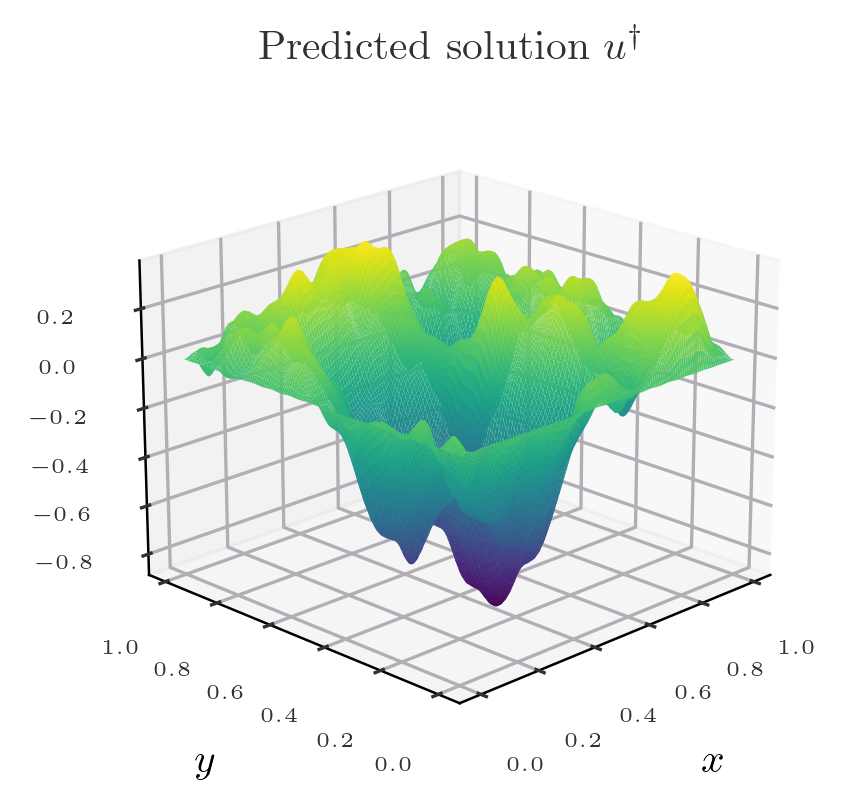

In [68]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

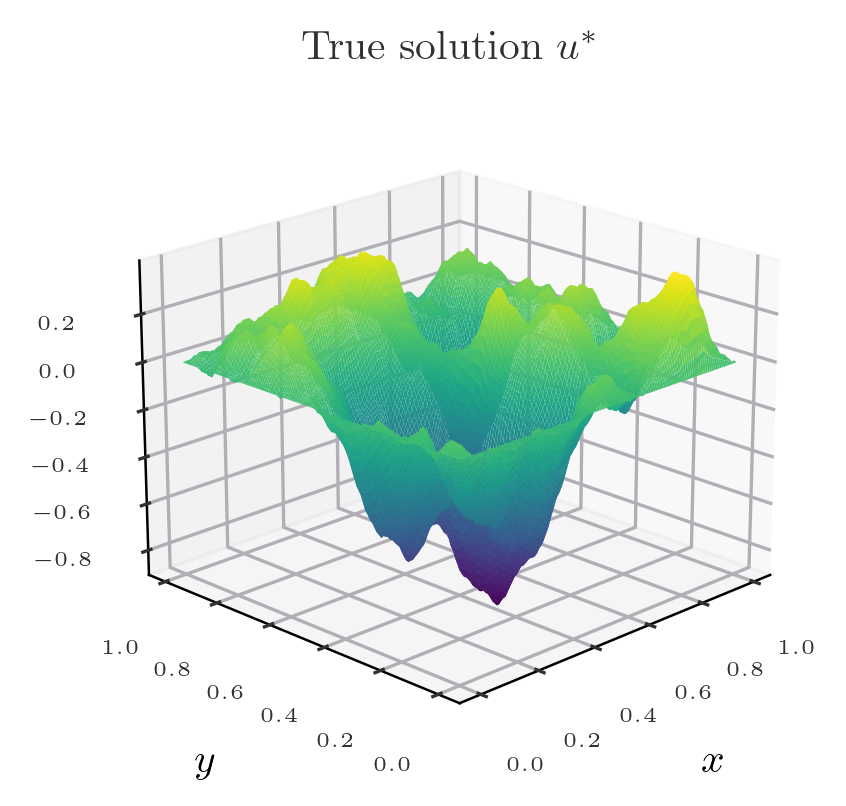

In [69]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [70]:
pred_transform = dst_2d(pred_grid)

In [71]:
# Compute the L^2 error and relative error
print(jnp.linalg.norm(pred_transform- coef_u),jnp.linalg.norm(pred_transform- coef_u)/jnp.linalg.norm(coef_u)) # Compute the L^2 error and relative error

0.02243759832866098 0.08370849299211269


In [72]:
# Compute the L^2 error and relative error
print(jnp.linalg.norm(pred_transform- u_trans),jnp.linalg.norm(pred_transform- u_trans)/jnp.linalg.norm(u_trans)) # Compute the L^2 error and relative error

0.030784445221027128 0.11500841573909139


In [73]:
from scipy import integrate

norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred_grid - u_values)**2, x_eval), x_eval))
norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u_values**2, x_eval), x_eval))
print(norm_diff, norm_diff/norm_u)

0.03139577435487901 0.11713194050471003


In [74]:
# Compute the L^2 error and relative error (of the true transform)
print(jnp.sqrt(jnp.sum((u_trans- coef_u)**2)), jnp.sqrt(jnp.sum(jnp.abs(u_trans- coef_u)**2))/jnp.sqrt(jnp.sum((coef_u)**2)))

0.013994822606281297 0.05221082456794606


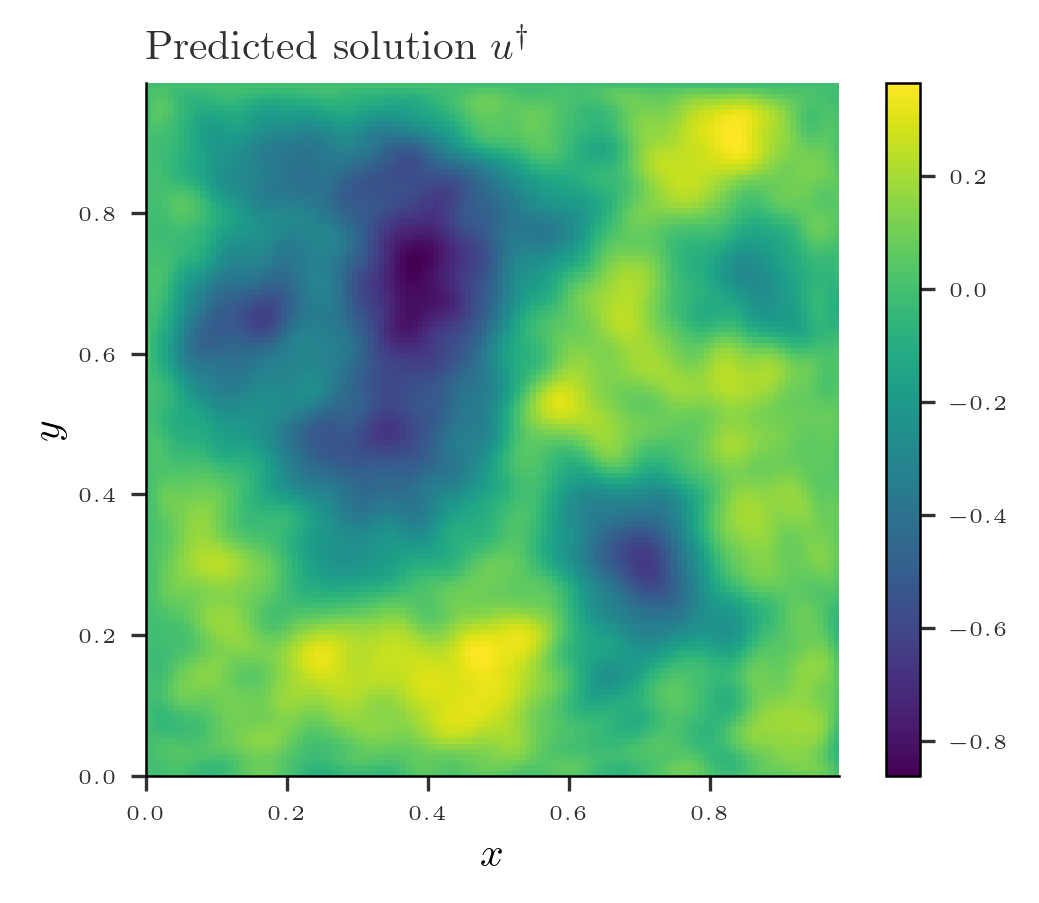

In [81]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x.min(), x.max(), y.min(), y.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

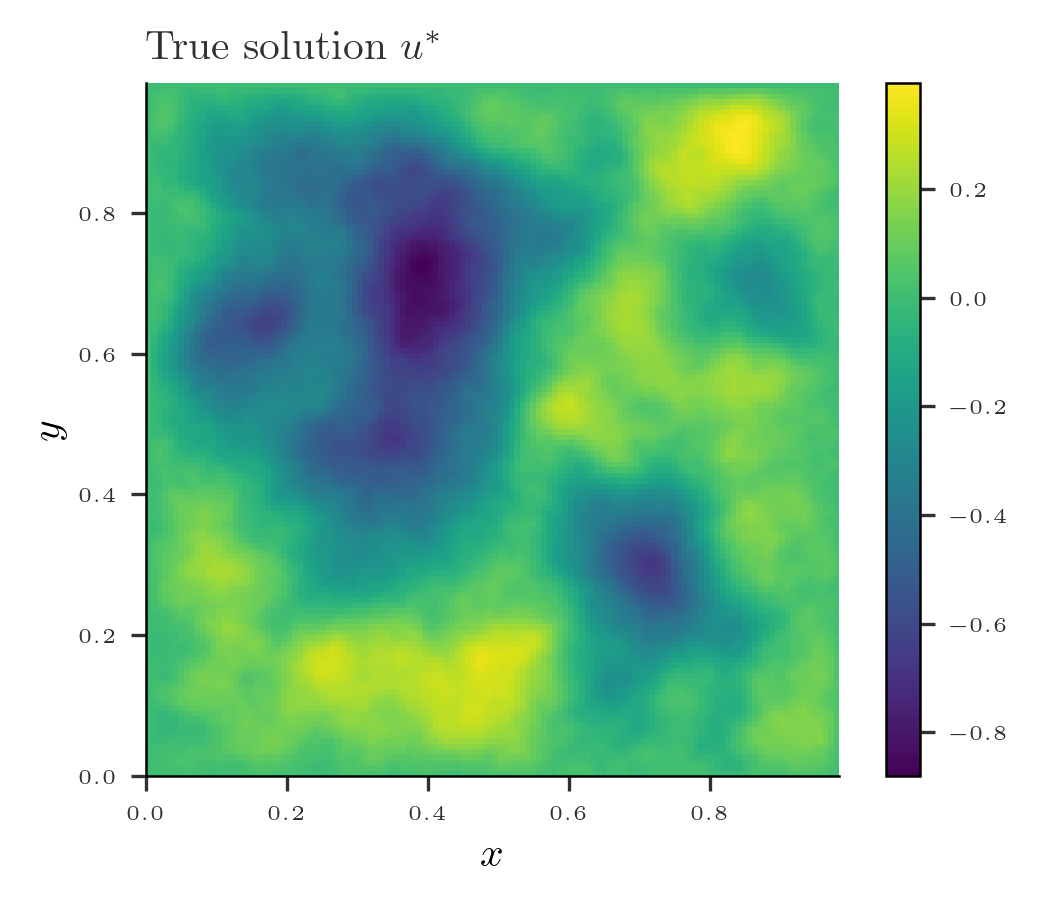

In [83]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x.min(), x.max(), y.min(), y.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

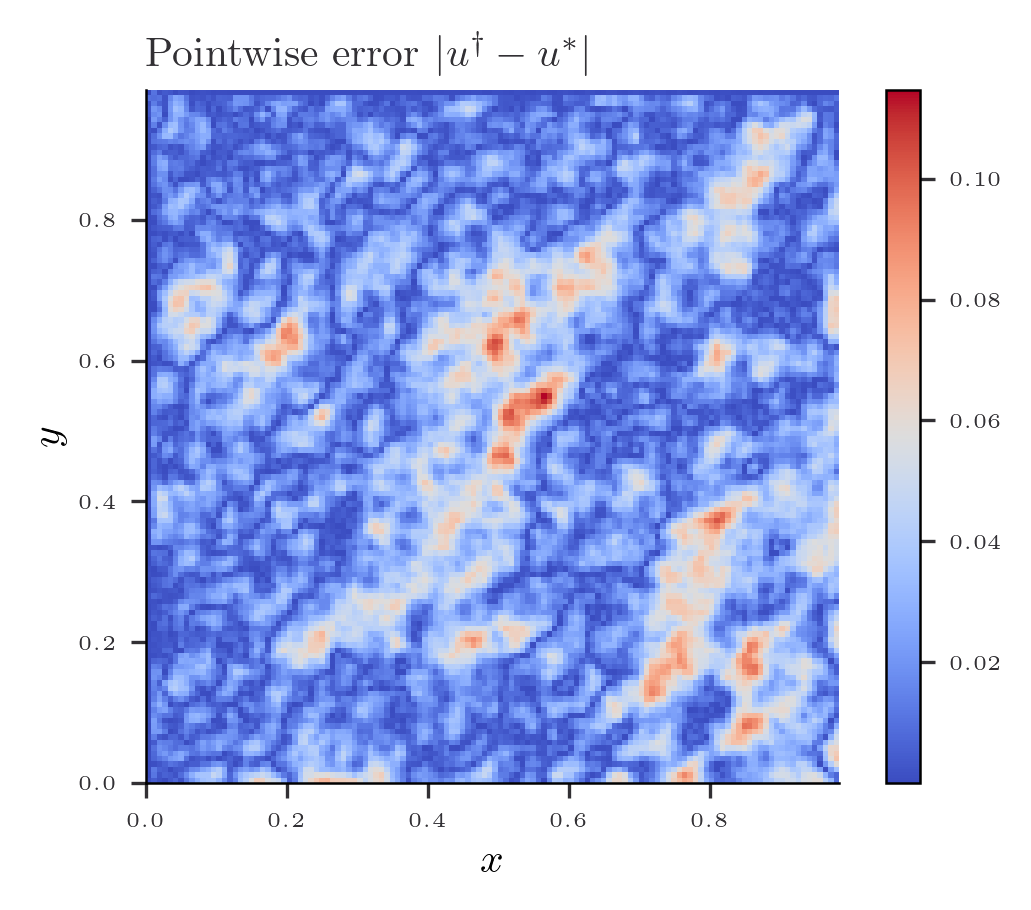

In [89]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x.min(), x.max(), y.min(), y.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()